<a href="https://colab.research.google.com/github/awagler2/NODE/blob/main/missing_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Read in the merged data

In [3]:
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
merged=pd.read_csv('/content/drive/MyDrive/merged_dataset_for_modeling.csv')
print(merged.shape)

(39946, 61)


In [5]:
    #a few functions for finding missing values
    missing_values = merged.isnull().sum()
    missing_values.to_csv("missing_dist.csv", index=True)
    print(missing_values)

unitid                               0
year                                 0
title_iv_indicator                 392
sector                             392
inst_control                       392
                                 ...  
room_board_charge                37356
exp_sal_wages_from_lib_budget    28399
exp_total_materials_services     28399
exp_total_operation_maint        28399
exp_total                        28399
Length: 61, dtype: int64


In [8]:
# Create the table
unitid_exp_total_table = merged[['unitid', 'exp_total']]

# Display the table (optional)
unitid_exp_total_table

#save to a CSV file (optional)
unitid_exp_total_table.to_csv('unitid_exp_total.csv', index=False)


In [11]:
def carry_forward_impute(df, id_col, value_cols):
    """Imputes missing values using a carry-forward method for multiple columns.

    Args:
        df: DataFrame with the data.
        id_col: Name of the ID column.
        value_cols: List of names of the value columns to impute.

    Returns:
        DataFrame with imputed values.
    """
    df_imputed = df.copy()
    for id_val in df[id_col].unique():
        # Get the subset of data for the current ID
        subset = df[df[id_col] == id_val]

        # Iterate over each value column
        for value_col in value_cols:
            # Find the indices of missing values within the subset
            missing_indices = subset[value_col].isnull()

            # Carry forward the last valid value
            last_valid = np.nan
            for i, is_missing in enumerate(missing_indices):
                if not is_missing:
                    last_valid = subset[value_col].iloc[i]
                elif not pd.isna(last_valid):
                    df_imputed.loc[subset.index[i], value_col] = last_valid

    return df_imputed

all_columns = merged.columns.tolist()
all_columns.remove('unitid')

# Example usage with a list of columns
cols_to_impute = ['exp_total',
    'exp_total_operation_maint',
    'exp_instruction',
    'exp_research',
    'exp_public_service',
    'exp_student_aid',
    'exp_auxiliary_enterprises',
    'exp_hospitals',
    'exp_independent_operations',
    'exp_other_expenses']
merged_imputed = carry_forward_impute(merged, 'unitid', all_columns)

# Verify imputation
print(merged_imputed.isnull().sum())


# Further processing or saving the imputed DataFrame
merged_imputed.to_csv('merged_imputed.csv', index=False)


['year', 'title_iv_indicator', 'sector', 'inst_control', 'offering_highest_degree', 'hbcu', 'tribal_college', 'cc_basic_2000', 'cc_undergrad_2015', 'inst_affiliation', 'cert_0_1_offered', 'cert_1_2_offered', 'assoc_offered', 'cert_2_4_offered', 'bach_offered', 'postbac_cert_offered', 'masters_offered', 'post_masters_cert_offered', 'doctors_research_offered', 'doctors_professional_offered', 'doctors_other_offered', 'other_degree_offered', 'open_admissions_policy', 'no_special_learning_opps', 'enrolled_undergrad_fulltime', 'tuition_varies', 'oncampus_housing', 'meal_plan', 'disability_indicator', 'oncampus_required', 'yellow_ribbon_program', 'rev_appropriations_fed', 'rev_appropriations_state', 'rev_appropriations_local', 'rev_grants_contracts_federal', 'rev_grants_contracts_state', 'rev_grants_contracts_local', 'rev_auxiliary_enterprises_gross', 'rev_other_operating', 'rev_other_nonoperating', 'rev_hospital', 'exp_instruc_total', 'exp_instruc_salaries', 'exp_research_total', 'exp_resear

In [12]:
# Filter for missing values in 'exp_total'
#this actually includes all missing (even when a institution has some non-missing)
missing_exp_total = merged_imputed[merged_imputed['exp_total'].isnull()]

# Group by 'unitid' and filter for groups with all missing values
unitids_with_all_missing = unitid_exp_total_table.groupby('unitid').filter(lambda group: group['exp_total'].isnull().all())

# Extract unique 'unitid' values
unitids_with_no_exp_total = unitids_with_all_missing['unitid'].unique()

# Print the result
#print(unitids_with_no_exp_total)

In [13]:
# Create indicator variables for missing values
indicator_vars = merged_imputed.isnull().astype(int)

# Rename columns for clarity
indicator_vars = indicator_vars.add_prefix('missing_')

# Concatenate the two DataFrames horizontally (column-wise).
combined_data = pd.concat([merged_imputed, indicator_vars], axis=1)

selected_data = combined_data[['exp_total', 'missing_exp_total']]

                   exp_total  missing_exp_total
exp_total                1.0                NaN
missing_exp_total        NaN                1.0


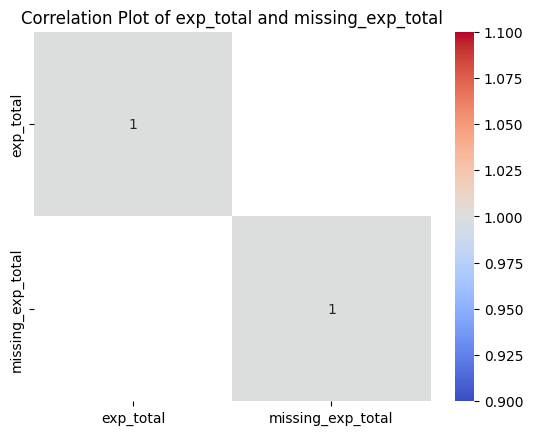

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = selected_data.corr(method="pearson",numeric_only=True)
print(correlation_matrix)
# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Plot of exp_total and missing_exp_total')
plt.show()

In [15]:
# prompt: Using dataframe unitid_exp_total_table: What proportion of the unitid_exp_total_table has missing values for exp_total

# Calculate the proportion of missing values in the 'exp_total' column.
missing_proportion = unitid_exp_total_table['exp_total'].isnull().sum() / len(unitid_exp_total_table)

# Print the result.
missing_proportion


np.float64(0.7109347619286036)

<Figure size 640x480 with 0 Axes>

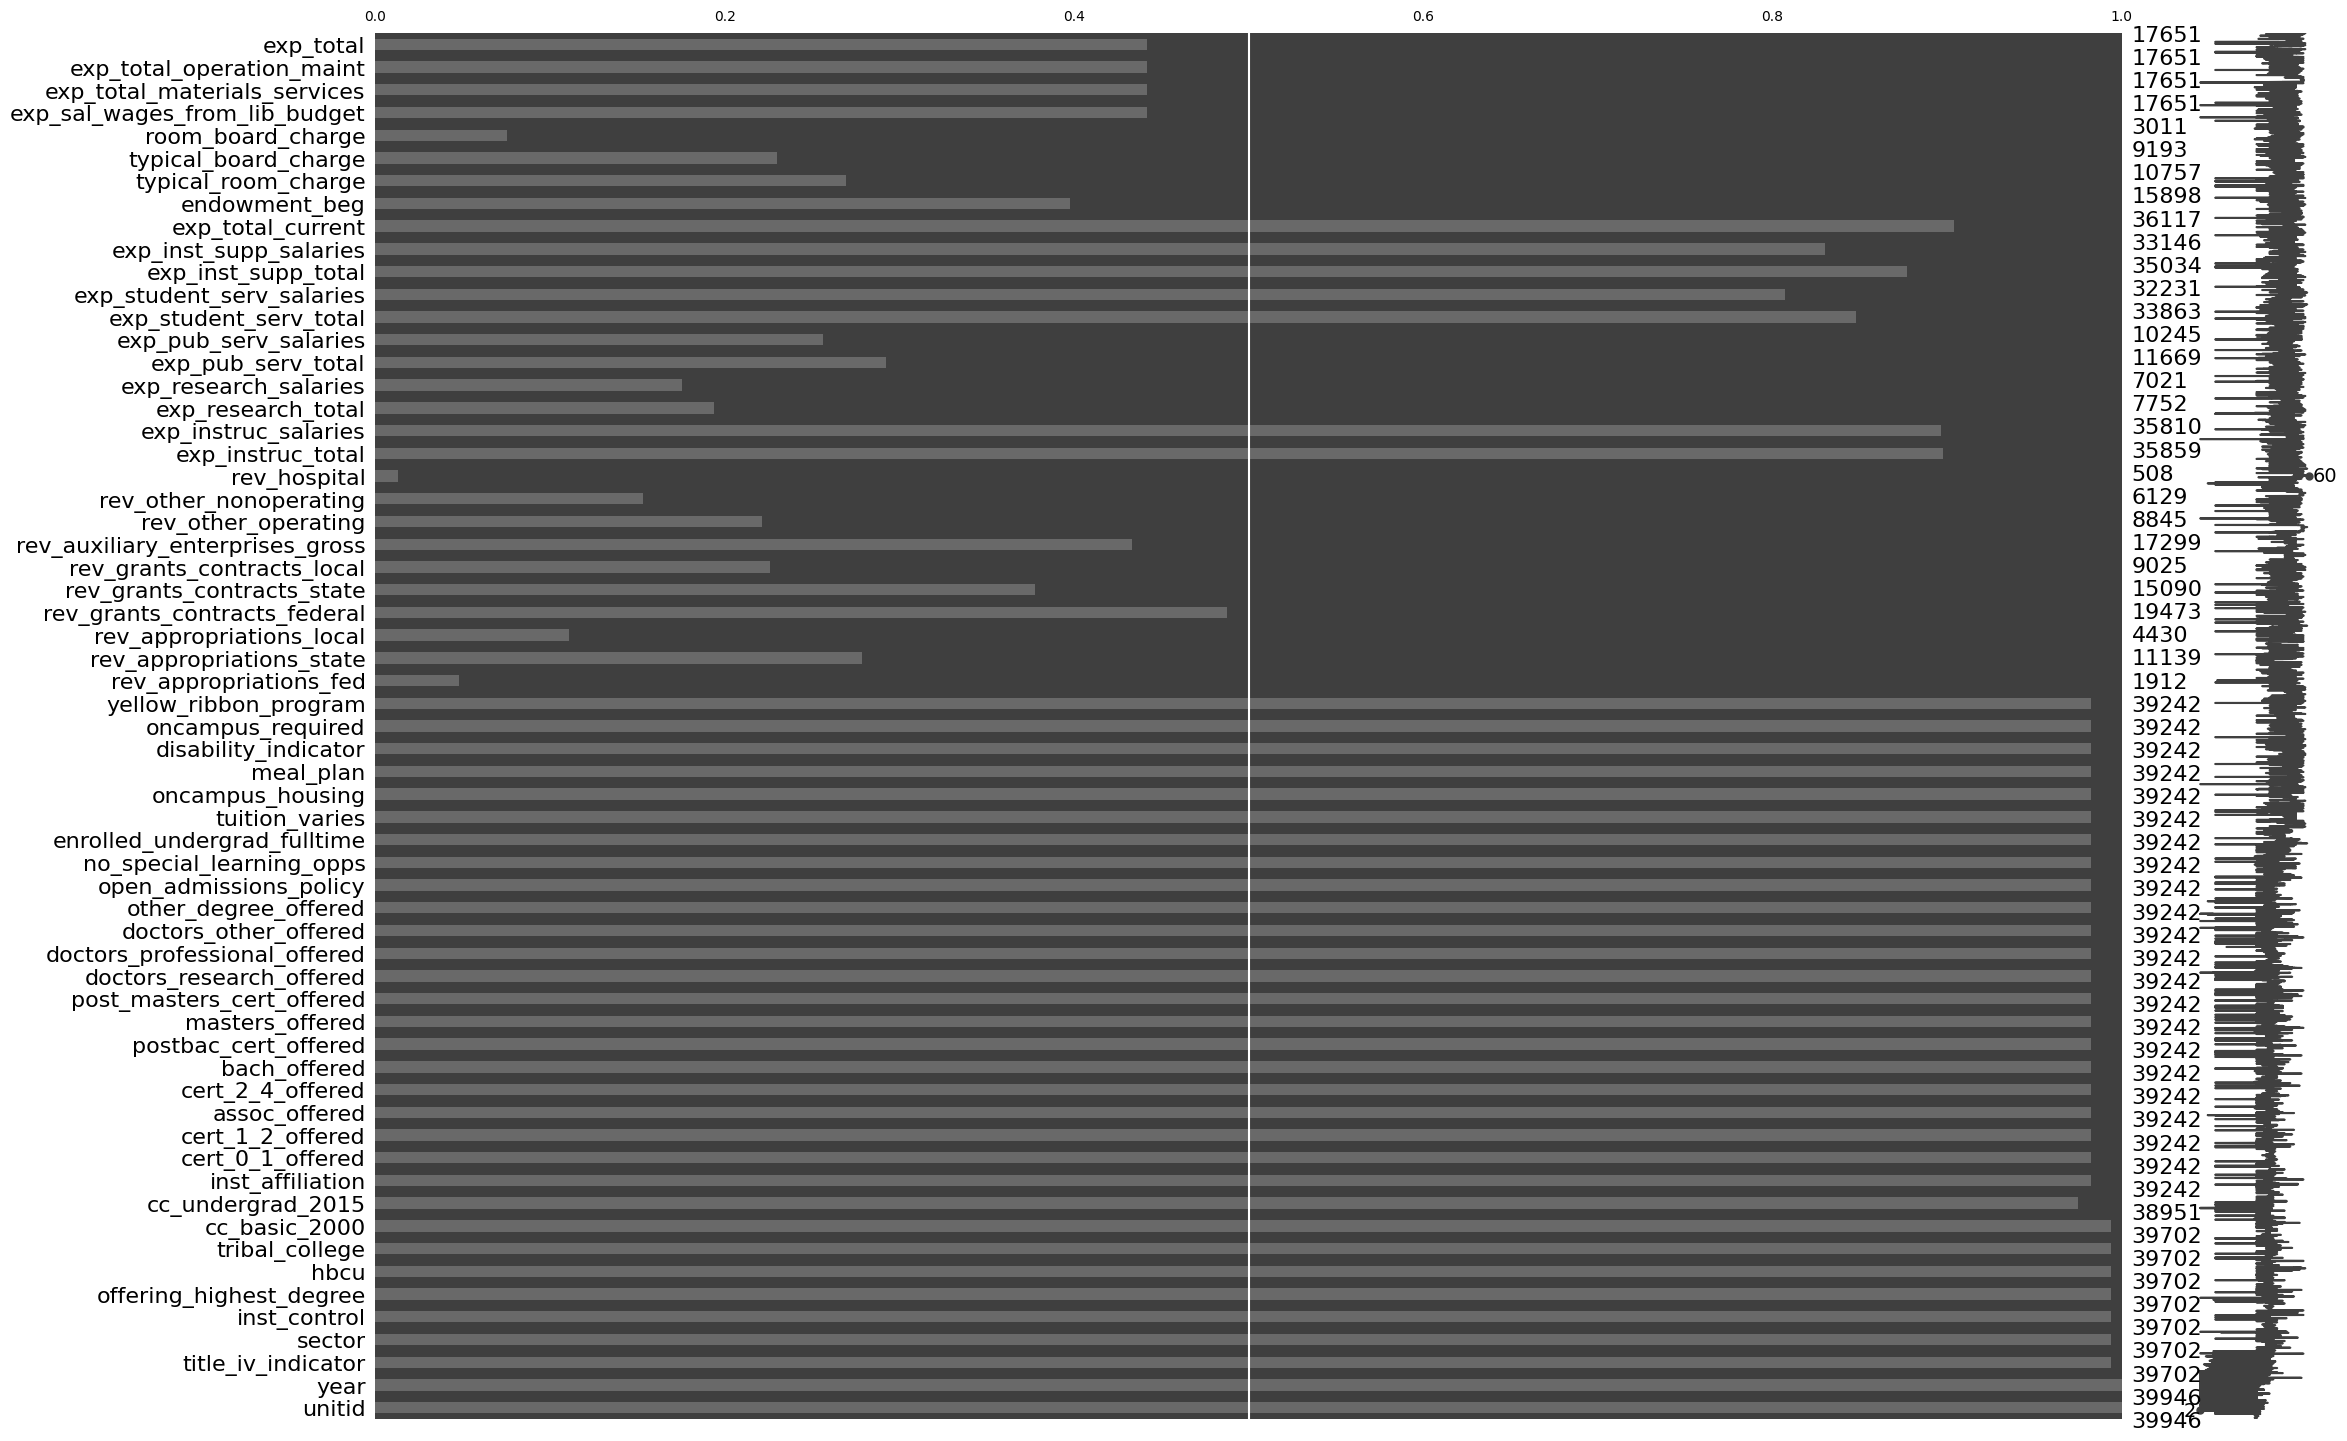

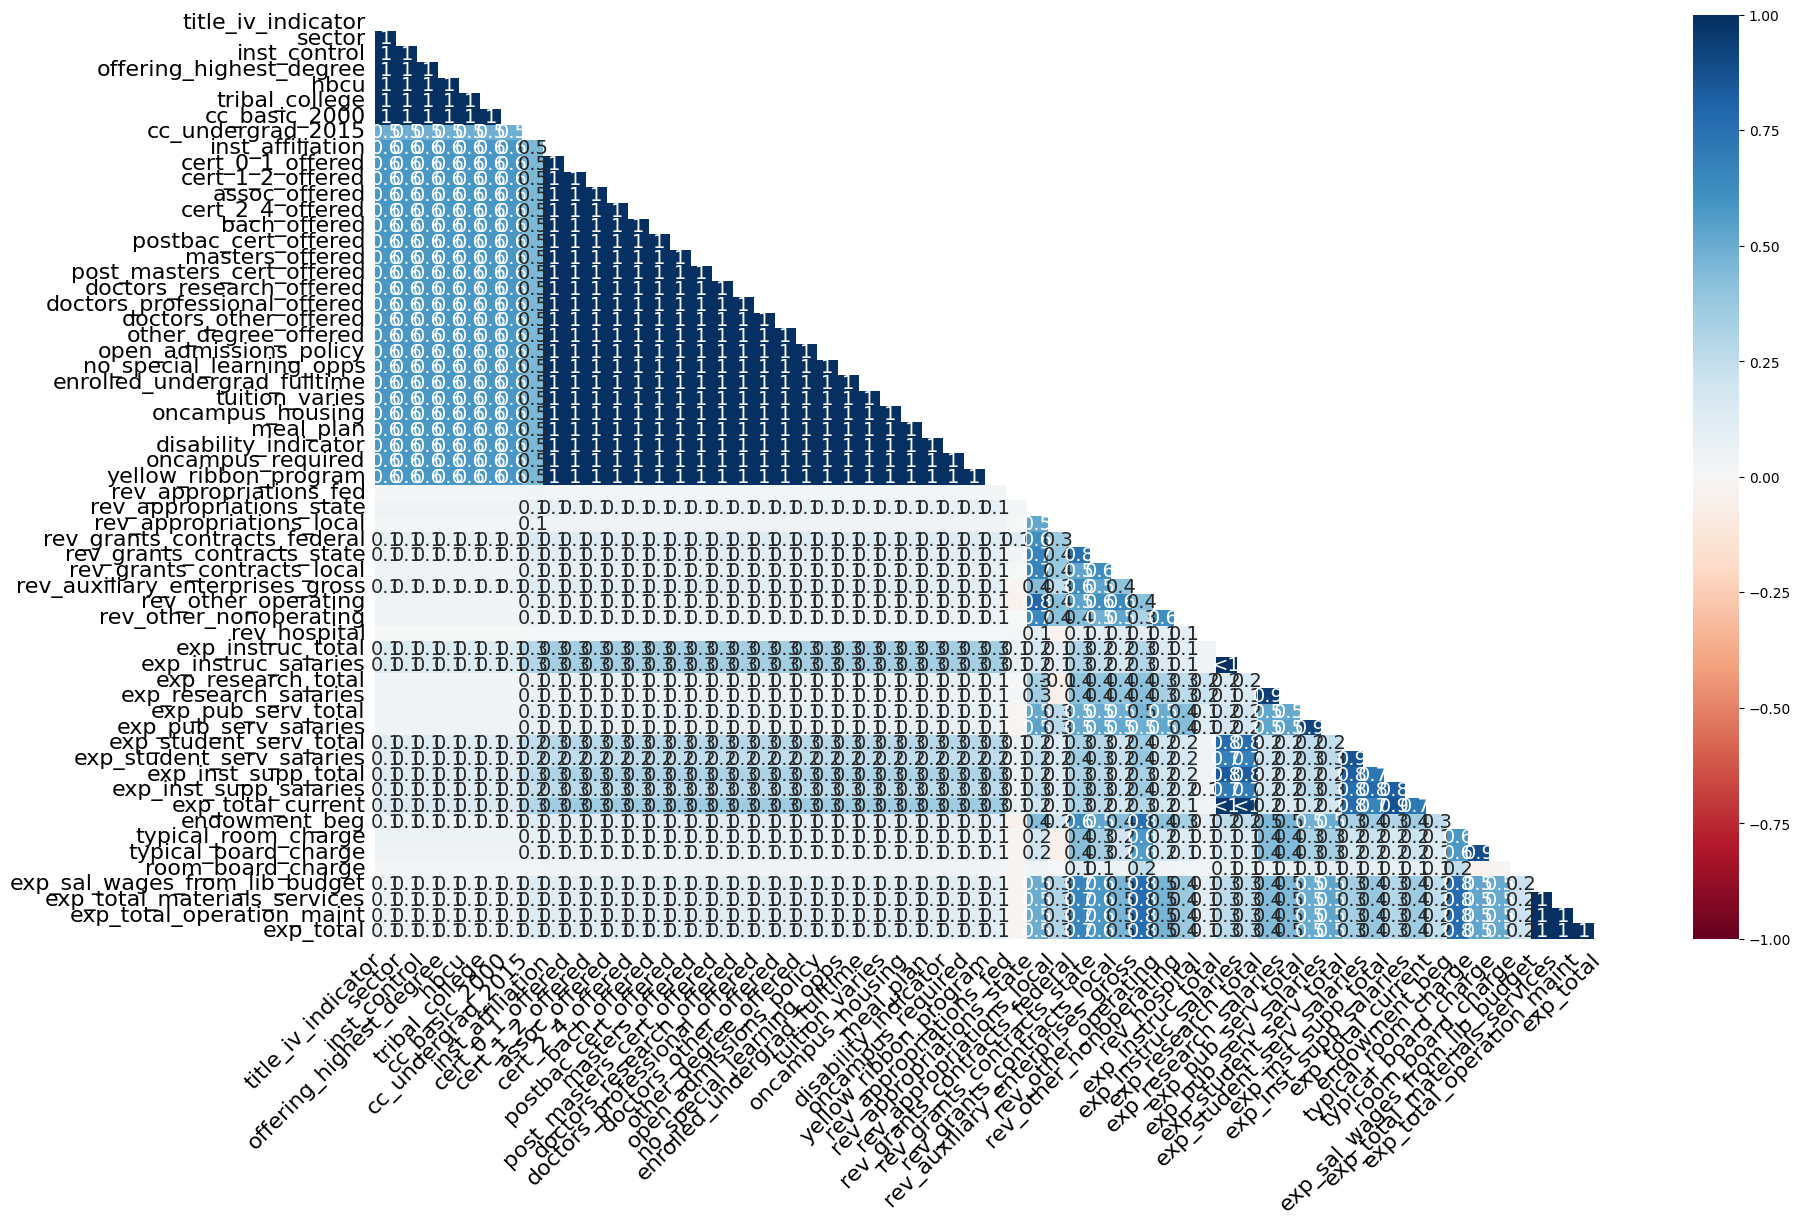

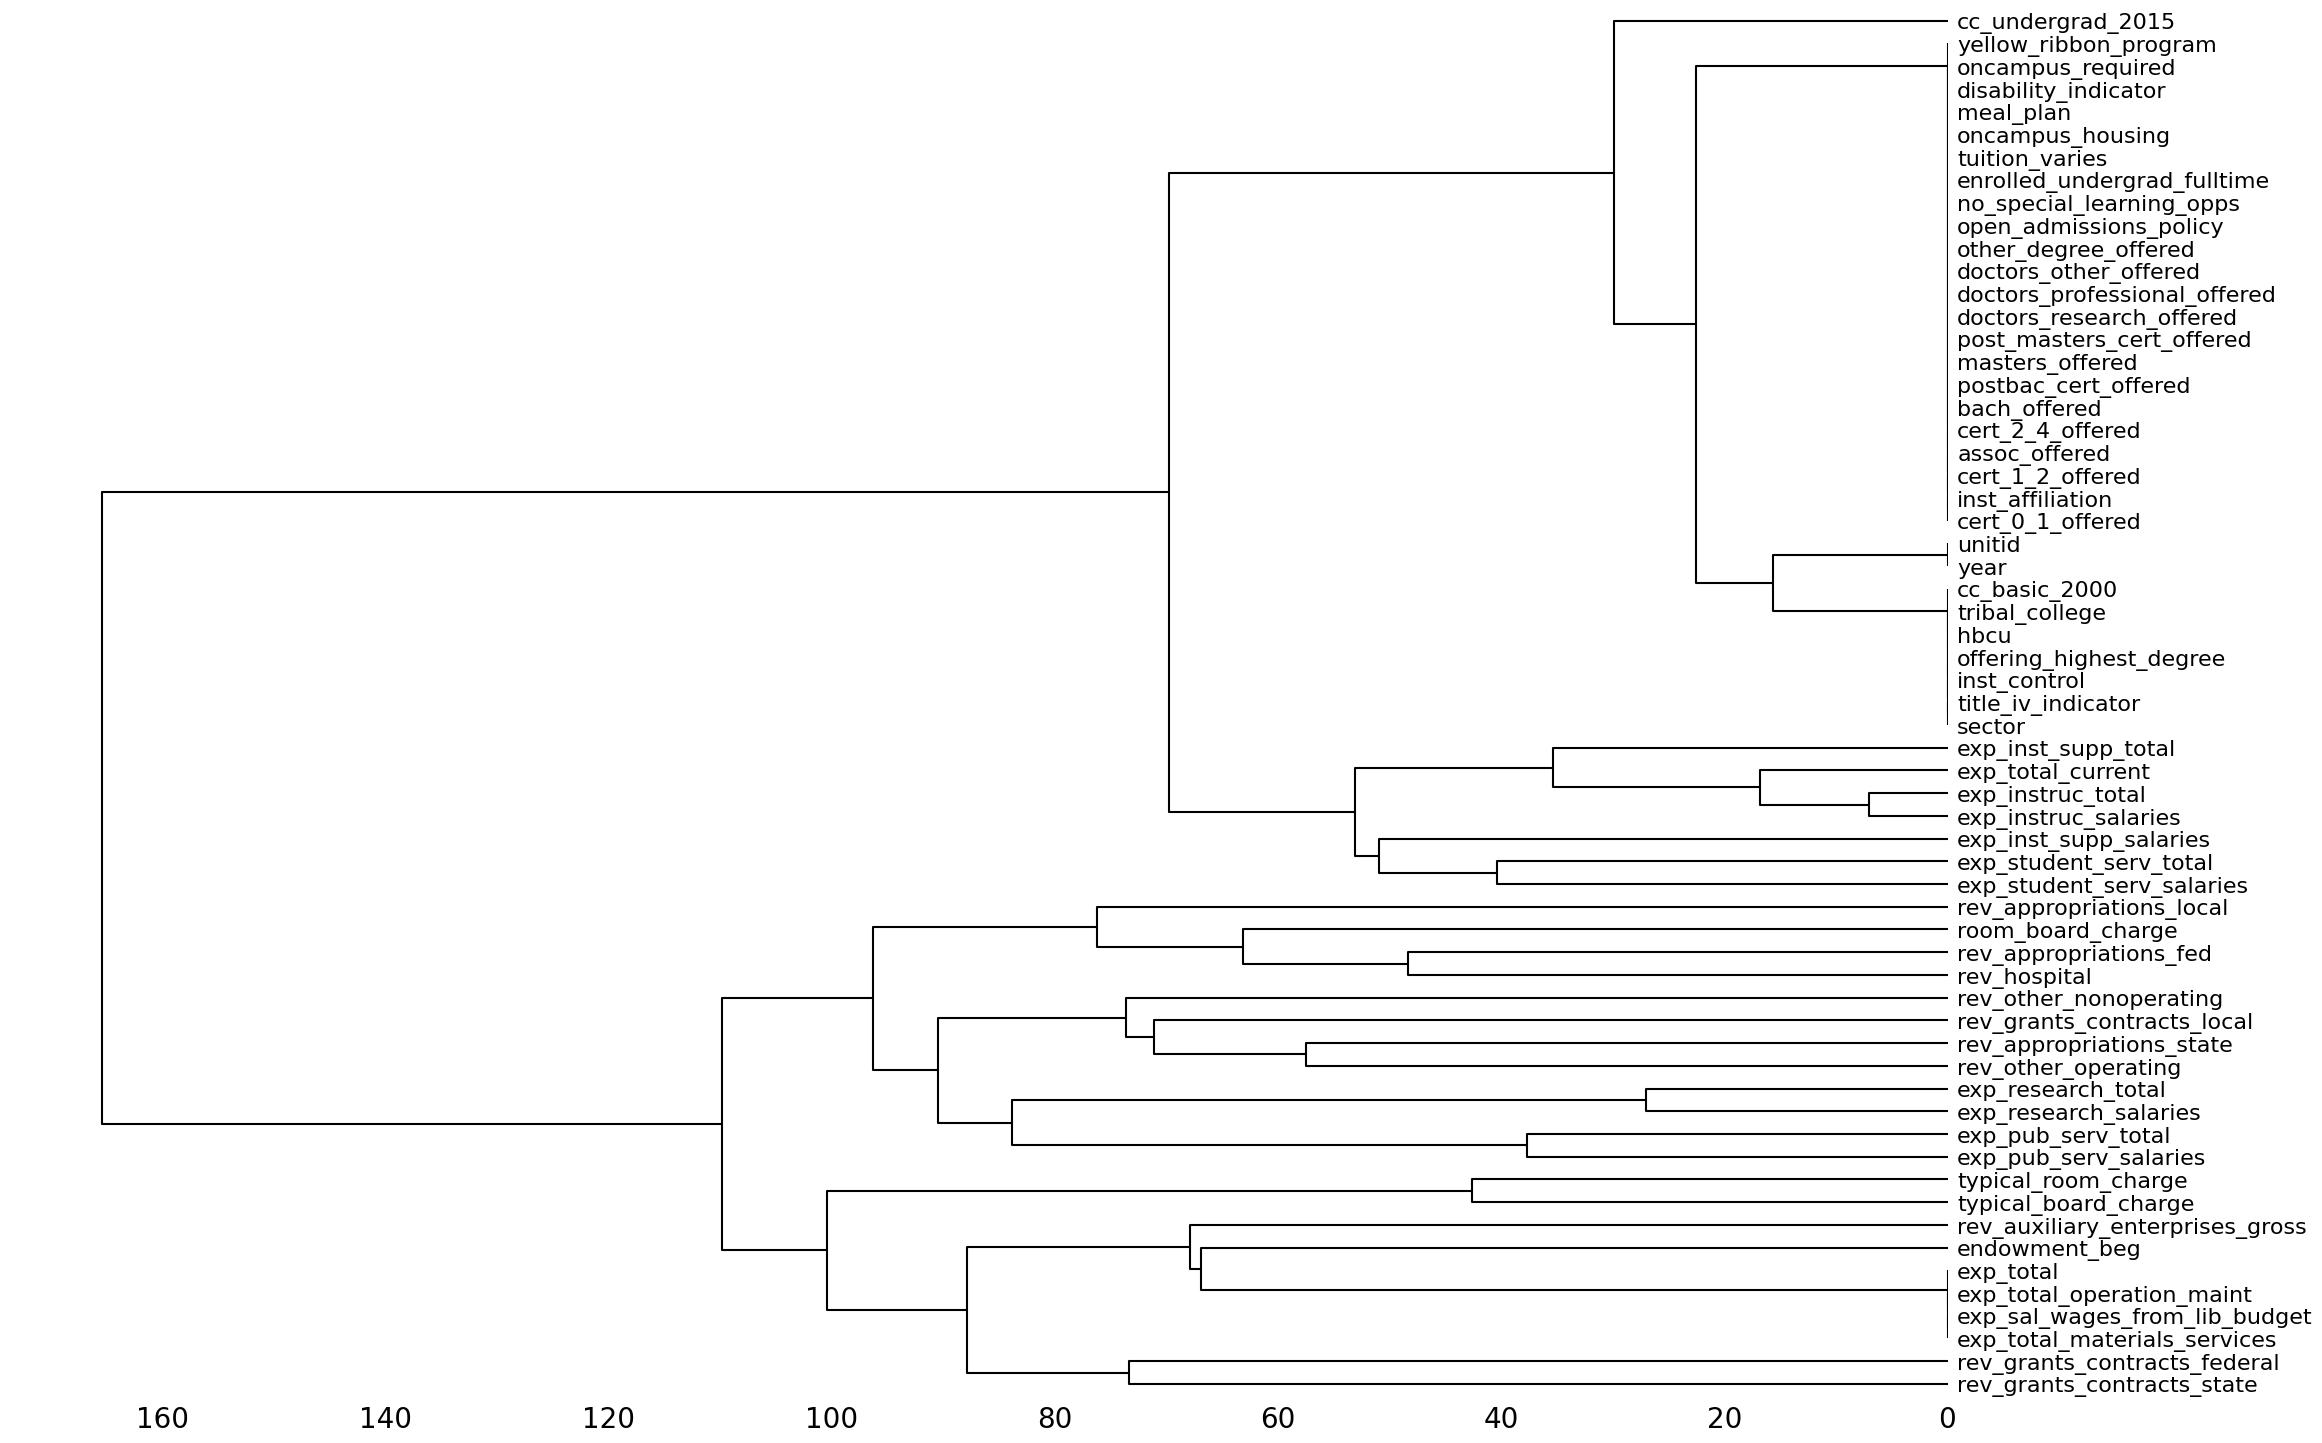

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [16]:
# Get the current figure before creating the plots
fig = plt.gcf()

mat = msno.matrix(merged_imputed)  # Example: Matrix plot
bar = msno.bar(merged_imputed)  # Example: Bar plot
heat = msno.heatmap(merged_imputed) # Example: Heatmap
dendo = msno.dendrogram(merged_imputed) # Example: Dendrogram

# Now save the entire figure using fig.savefig()
fig.savefig("matrix_plot.png")

# Get a new figure for the next plot
fig = plt.figure()
bar.figure.savefig("bar_plot.png")  # Save the figure associated with the bar plot

fig = plt.figure()
heat.figure.savefig("heatmap_plot.png")  # Save the figure associated with the heatmap plot

fig = plt.figure()
dendo.figure.savefig("dendrogram_plot.png")  # Save the figure associated with the dendrogram plot

In [9]:
def calculate_missingness_distances(df):
    """
    Calculates the variable-wise and subject-wise missingness distances
    for a given Pandas DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame containing the data.
                           Missing values should be represented as NaN.

    Returns:
        tuple: A tuple containing two distance matrices:
               - variable_missingness_distance (pd.DataFrame):
                 DataFrame with variable-wise missingness distances.
               - subject_missingness_distance (pd.DataFrame):
                 DataFrame with subject-wise missingness distances.
    """
    # 1. Create the missingness matrix M
    missingness_matrix = df.isnull().astype(int)

    # 2. Calculate Variable-wise Missingness Distance (Dv) [1]
    # The number of variables is the number of columns in the DataFrame
    num_variables = missingness_matrix.shape[1]  # Changed from shape[2] to shape[1]
    variable_missingness_distance = pd.DataFrame(
        np.zeros((num_variables, num_variables)),
        index=df.columns,
        columns=df.columns
    )

    for j_idx, j_col in enumerate(df.columns):
        for j_prime_idx, j_prime_col in enumerate(df.columns):
            if j_idx < j_prime_idx:
                # Proportion of discordant missingness indicators [1]
                discordant_count = np.sum(missingness_matrix[j_col] != missingness_matrix[j_prime_col])
                distance = discordant_count / len(df)
                variable_missingness_distance.loc[j_col, j_prime_col] = distance
                variable_missingness_distance.loc[j_prime_col, j_col] = distance
            elif j_idx == j_prime_idx:
                variable_missingness_distance.loc[j_col, j_prime_col] = 0.0

    # 3. Calculate Subject-wise Missingness Distance (Ds) [3]
    # num_subjects is the number of rows in the DataFrame
    num_subjects = missingness_matrix.shape[0]  # Changed to shape[0] to get the number of rows
    subject_missingness_distance = pd.DataFrame(
        np.zeros((num_subjects, num_subjects)),
        index=df.index,
        columns=df.index
    )

    for i_idx, i_row in enumerate(df.index):
        for i_prime_idx, i_prime_row in enumerate(df.index):
            if i_idx < i_prime_idx:
                # Proportion of discordant missingness indicators [3]
                discordant_count = np.sum(missingness_matrix.loc[i_row] != missingness_matrix.loc[i_prime_row])
                distance = discordant_count / num_variables
                subject_missingness_distance.loc[i_row, i_prime_row] = distance
                subject_missingness_distance.loc[i_prime_row, i_row] = distance
            elif i_idx == i_prime_idx:
                subject_missingness_distance.loc[i_row, i_prime_row] = 0.0

    return variable_missingness_distance, subject_missingness_distance